# OCR tables and parse the output

In this tutorial, we will illustrate how easily the `layoutparser` APIs can be used for  

1. Recognizing texts in images and store the results with the specified OCR engine
2. Postprocessing of the textual results to create structured data 


In [1]:
import layoutparser as lp 
import cv2
import matplotlib.pyplot as plt
%matplotlib inline 
import pandas as pd
import numpy as np
import pytesseract


In [2]:
# define your ocr agent --> tesseract in this case
ocr_agent = lp.TesseractAgent(languages='eng')

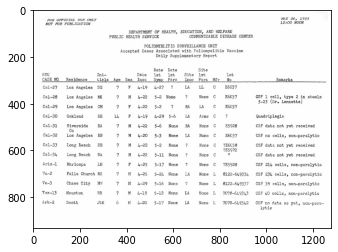

In [3]:
#load your image
image = cv2.imread('data/example-table.jpeg')
plt.imshow(image);

In [4]:
# Convert the image from BGR (cv2 default loading style)
# to RGB
image = image[..., ::-1]

In [5]:
# load detectron layout model for object detection
model = lp.Detectron2LayoutModel('lp://PubLayNet/faster_rcnn_R_50_FPN_3x/config', 
                                 extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.8],
                                 label_map={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"})

The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


In [7]:
# Detect the layout of the input image
layout = model.detect(image)

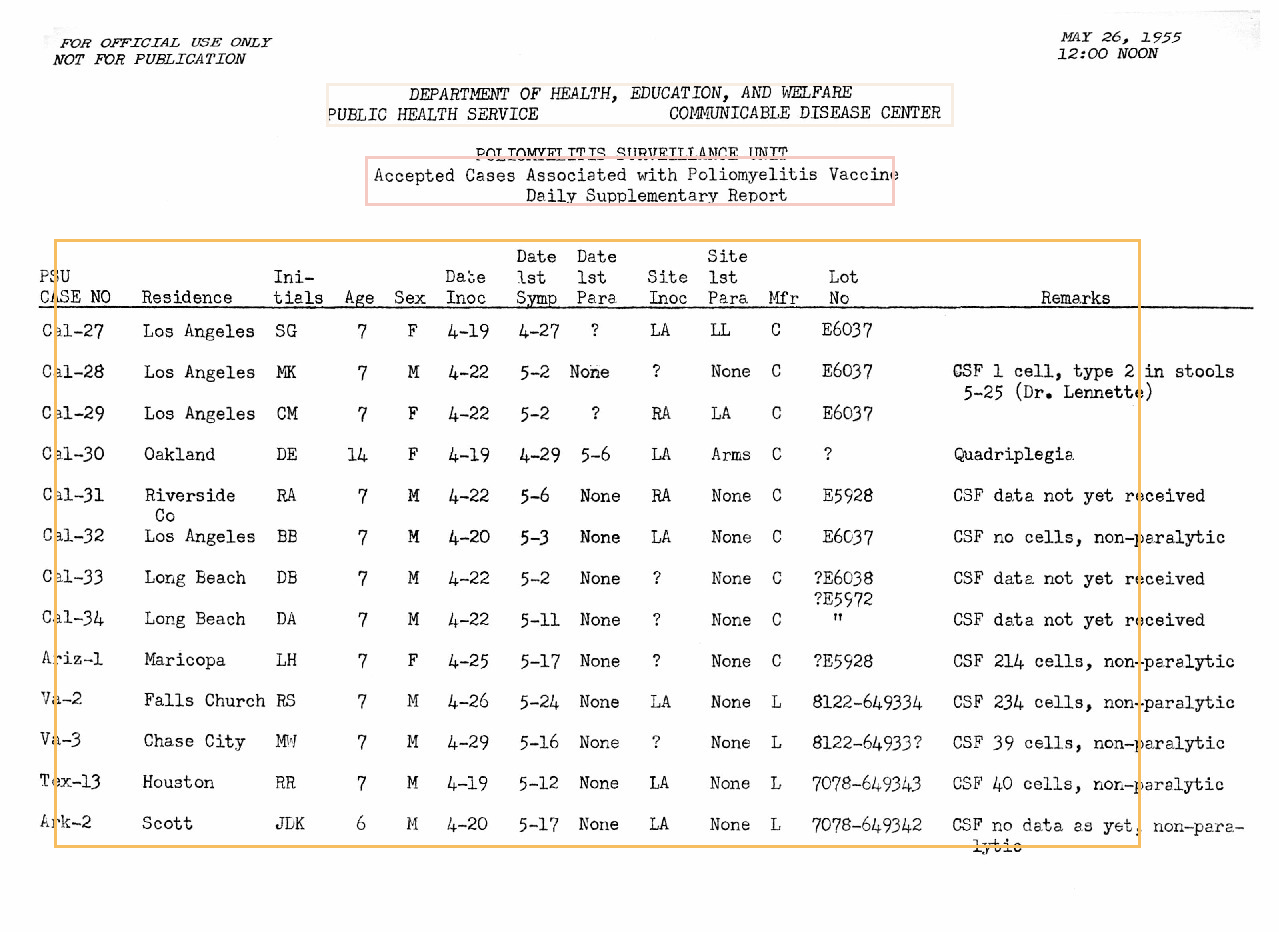

In [8]:
# Show the detected layout of the input image
lp.draw_box(image, layout, box_width=3)

In [ ]:
type(layout)

In [ ]:
layout[1]

In [ ]:
layout[2]

In [ ]:
text_blocks = lp.Layout([b for b in layout if b.type=='Text'])
figure_blocks = lp.Layout([b for b in layout if b.type=='Figure'])

In [ ]:
text_blocks = lp.Layout([b for b in text_blocks \
                   if not any(b.is_in(b_fig) for b_fig in figure_blocks)])

In [ ]:
h, w = image.shape[:2]

left_interval = lp.Interval(0, w/2*1.05, axis='x').put_on_canvas(image)

left_blocks = text_blocks.filter_by(left_interval, center=True)
left_blocks.sort(key = lambda b:b.coordinates[1])

right_blocks = [b for b in text_blocks if b not in left_blocks]
right_blocks.sort(key = lambda b:b.coordinates[1])

# And finally combine the two list and add the index
# according to the order
text_blocks = lp.Layout([b.set(id = idx) for idx, b in enumerate(left_blocks + right_blocks)])

In [ ]:
for block in text_blocks:
    segment_image = (block
                       .pad(left=5, right=5, top=5, bottom=5)
                       .crop_image(image))
        # add padding in each image segment can help
        # improve robustness 
        
    text = ocr_agent.detect(segment_image)
    block.set(text=text, inplace=True)

In [ ]:
for txt in text_blocks.get_texts():
    print(txt, end='\n---\n')

## END

In [9]:
res = ocr_agent.detect(image, return_response=True)

In [12]:
text = ocr_agent.detect(image, return_response=True)

In [13]:
print(text)

{'text': 'FOR OFFICIAL\n\nUSE ONLY\n\nMAY 26, 1955\n\n \n\nNOT FOR PUBLICATION 12:00. 8008,\nDEPARTMENT OF HEALTH, EDUCATION, AND WELFARE\nPUBLIC HEALTH SERVICE COMMUNICABLE DISEASE CENTER\nPOLIOMYELITIS SURVEILLANCE UNIT\nAccepted Cases Associated with Poliomyelitis Vaccine\nDaily Supplementary Report\nDate Date Site\nPSU Ini- Date 1st lst Site 1st Lot\nCASE NO Residence tials Age Sex Inoc Symp Para Inoc Para Mfr No Renarks\nCal-27 Los Angeles SG 7 F 419 4-27 2 TA LL oC E6O37\nCal-28 Los Angeles MK 7 M 4-22 5-2 None ? None C 86037 GSF 1 cell, type 2 in stools\n5-25 (Dr. Lennette)\nCal-29 Los Angeles OM 7 F 22 5-2 ? RA LA CC B6037\nCal-~30 Oakland DE 14 Fo 4-19 4-29 5-6 LA Arms © 2 Quadriplegia\nCal-31 Riverside = RA 7 M 4-22 5-6 None RA None C 55928 CSF data not yet received\nCo\n\nCal-32 Los Angeles BB 7  M 4-20 5-3 None LA None C 6037 CSF no cells, non-peralytic\nGel-33 Long Beach DB 7 M 4-22 5-2 None ? None C 56038 CSF date not yet received\n\nE5972\nCal-34 Long Beach DA 7 M 4-22 5

In [10]:
texts  = ocr_agent.gather_text_annotations(res) 
    # collect all the texts without coordinates
layout = ocr_agent.gather_full_text_annotation(res, agg_level=lp.GCVFeatureType.WORD)
    # collect all the layout elements of the `WORD` level

AttributeError: 'TesseractAgent' object has no attribute 'gather_text_annotations'

## Load images and send for OCR


The `ocr_agent.detect` method can take the image array, or simply the path of the image, for OCR. By default it will return the text in the image, i.e., `text = ocr_agent.detect(image)`. 

However, as the layout is complex, the text information is not enough: we would like to directly analyze the response from GCV Engine. We can set the `return_response` to `True`. This feature is also supported for other OCR Engines like `TesseractOCRAgent`.

In [ ]:
res = ocr_agent.detect(image, return_response=True)

# Alternative
# res = ocr_agent.detect('data/example-table.jpeg', return_response=True) 

## Parse the OCR output and visualize the layout

As defined by GCV, there are two different types of output in the response: 

1. text_annotations: 

    In this format, GCV automatically find the best aggregation 
    level for the text, and return the results in a list. We can  
    use the `ocr_agent.gather_text_annotations` to reterive this 
    type of information.

2. full_text_annotations

    To support better user control, GCV also provides the 
    `full_text_annotation` output, where it returns the hierarchical 
    structure of the output text. To process this output, we provide 
    the `ocr_agent.gather_full_text_annotation` function to aggregate 
    the texts of the given aggregation level. 
    
    There are 5 levels specified in `GCVFeatureType`, namely: `PAGE`, 
    `BLOCK`, `PARA`, `WORD`, `SYMBOL`.

In [ ]:
#image_file = 'Downloads/test.jpeg'
image_file = '/Users/lucamossink/Downloads/test.jpeg'
import pytesseract as pyt
#image = cv2.imread('data/example-table.jpeg')

In [ ]:
text = lp.ocr.TesseractAgent(languages='eng')

In [ ]:
text = ocr_agent.detect(image, return_response=True)

In [ ]:
print(text)

And we can use the `draw_box` or `draw_text` functions to quickly visualize the detected layout and text information.


These functions are highly customizable. You can change styles of the drawn boxes and texts easily. Please check the [documentation](https://layout-parser.readthedocs.io/en/latest/api_doc/visualization.html#layoutparser.visualization.draw_text) for the detailed explanation of the configurable parameters. 

As shown below, the `draw_text` function generates a visualization that:

1. it draws the detected layout with text on the left side and shows the original image on the right canvas for comparison.
2. on the text canvas (left), it also draws a red bounding box for each text region.

In [ ]:
lp.draw_text(image, layout, font_size=12, with_box_on_text=True,
             text_box_width=1)

## Filter the returned text blocks 

We find the coordinates of residence column are in the range of $y\in(300,833)$ and $x\in(132, 264)$. The `layout.filter_by` function can be used to fetch the texts in the region. 

Note: As the OCR engine usually does not provide advanced functions like table detection, the coordinates are found manually by using some image inspecting tools like GIMP.

In [ ]:
filtered_residence = layout.filter_by(
    lp.Rectangle(x_1=132, y_1=300, x_2=264, y_2=840)
)
lp.draw_text(image, filtered_residence, font_size=16)

And similarily, we can do that for the `lot_number` column. As sometimes there could be irregularities in the layout as well as the OCR outputs, the `layout.filter_by` function also supports a `soft_margin` argument to handle this issue and generate more robust outputs. 


In [ ]:
filter_lotno = layout.filter_by(
    lp.Rectangle(x_1=810, y_1=300, x_2=910, y_2=840),
    soft_margin = {"left":10, "right":20} # Without it, the last 4 rows could not be included
)
lp.draw_text(image, filter_lotno, font_size=16)

### Group Rows based on hard-coded parameteres

As there are 13 rows, we can iterate the rows and fetch the row-based information:

In [ ]:
y_0 = 307
n_rows = 13
height = 41
y_1 = y_0+n_rows*height

row = []
for y in range(y_0, y_1, height):
    
    interval = lp.Interval(y,y+height, axis='y')
    residence_row = filtered_residence.\
        filter_by(interval).\
        get_texts()

    lotno_row = filter_lotno.\
        filter_by(interval).\
        get_texts()
    
    row.append([''.join(residence_row), ''.join(lotno_row)])

In [ ]:
row

### An Alternative Method - Adaptive Grouping lines based on distances 

In [ ]:
blocks = filter_lotno

blocks = sorted(blocks, key = lambda x: x.coordinates[1])
    # Sort the blocks vertically from top to bottom 
distances = np.array([b2.coordinates[1] - b1.coordinates[3] for (b1, b2) in zip(blocks, blocks[1:])])
    # Calculate the distances: 
    # y coord for the upper edge of the bottom block - 
    #   y coord for the bottom edge of the upper block
    # And convert to np array for easier post processing
plt.hist(distances, bins=50);
plt.axvline(x=3, color='r');
    # Let's have some visualization 

According to the distance distribution plot, as well as the OCR results visualization, we can conclude:

- For the negative distances, it's because there are texts in the same line, e.g., "Los Angeles"
- For the small distances (indicated by the red line in the figure), they are texts in the same table row as the previous one 
- For larger distances, they are generated from texts pairs of different rows 

In [ ]:
distance_th = 0

distances = np.append([0], distances) # Append a placeholder for the first word
block_group = (distances>distance_th).cumsum() # Create a block_group based on the distance threshold 

block_group

In [ ]:
# Group the blocks by the block_group mask 
grouped_blocks = [[] for i in range(max(block_group)+1)]
for i, block in zip(block_group, blocks):
    grouped_blocks[i].append(block) 

Finally let's create a function for them

In [ ]:
def group_blocks_by_distance(blocks, distance_th):

    blocks = sorted(blocks, key = lambda x: x.coordinates[1])
    distances = np.array([b2.coordinates[1] - b1.coordinates[3] for (b1, b2) in zip(blocks, blocks[1:])])

    distances = np.append([0], distances)
    block_group = (distances>distance_th).cumsum()

    grouped_blocks = [lp.Layout([]) for i in range(max(block_group)+1)]
    for i, block in zip(block_group, blocks):
        grouped_blocks[i].append(block) 
        
    return grouped_blocks

In [ ]:
A = group_blocks_by_distance(filtered_residence, 5)
B = group_blocks_by_distance(filter_lotno, 10) 

# And finally we combine the outputs 
height_th = 30
idxA, idxB = 0, 0

result = []
while idxA < len(A) and idxB < len(B):
    ay = A[idxA][0].coordinates[1]
    by = B[idxB][0].coordinates[1]
    ares, bres = ''.join(A[idxA].get_texts()), ''.join(B[idxB].get_texts())
    if abs(ay - by) < height_th:
        idxA += 1; idxB += 1
    elif ay < by:
        idxA += 1; bres = ''
    else: 
        idxB += 1; ares = ''
    result.append([ares, bres])
    
result

As we can find, there are mistakes in the 5th and 6h row - `Riverside Co` and `LosAngeles` are wrongly combined. This is because the extra row `co` disrupted the row segmentation algorithm. 

## Save the results as a table

In [ ]:
df = pd.DataFrame(row, columns=['residence', 'lot no'])
df

In [ ]:
df.to_csv('./data/ocred-example-table.csv', index=None)